In [1]:
library(tidyverse)
library(WGCNA)
library(glmnet)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: 'fastcluster'


The following object is masked from 'package:stats':

    hclust





Attaching package: 'WGCNA'


The following object is masked from 'package:stats':

    cor


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1



In [2]:
# Define constants
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

event_code <- list("Alive" = 0, "Dead" = 1)
# covariate_cols_no_figo <- c("age_at_diagnosis", "race", "ethnicity")
# covariate_cols <- c("figo_stage", covariate_cols_no_figo)
covariate_cols <- c("figo_stage")
dep_cols <- c("vital_status", "survival_time")


In [3]:
dset_idx <- 1
save_res <- FALSE

In [4]:
survival_path <- paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/survival_data.tsv")
survival_df <- load_survival_df(survival_path, event_code)
demg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_demg_list.txt"))


-- Column specification ------------------------------------------------------------------------------------------------------------------------
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  survival_time = col_double(),
  figo_stage = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race = col_character(),
  ethnicity = col_character()
)




In [5]:
# Load and filter survival data
filtered_survival_df <- survival_df %>%
    decode_figo_stage(to = "c") %>%
    dplyr::select(sample_name, figo_stage) %>% # make sure using same samples as classification models
    dplyr::filter(rowSums(is.na(.)) == 0) %>%
    dplyr::select(sample_name, figo_stage)

# Load normalized matrisome count data
norm_matrisome_counts_path <- paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/norm_matrisome_counts.tsv")
norm_survival_counts_t_df <- read_tsv(norm_matrisome_counts_path) %>%
    dplyr::select(c("geneID", filtered_survival_df$sample_name)) %>%
    transpose_df("geneID", "sample_name")

# Combine survival data and normalized count data
joined_df <- filtered_survival_df %>%
    inner_join(norm_survival_counts_t_df, by = "sample_name")
#     dplyr::select(one_of(c("sample_name", "figo_stage", demg_list)))


-- Column specification ------------------------------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  geneID = col_character()
)
i Use `spec()` for the full column specifications.




In [6]:
y <- as.vector(joined_df$figo_stage)

x <- as.matrix(
    joined_df %>%
        dplyr::select(-c(sample_name, figo_stage))
)
rownames(x) <- joined_df$sample_name

In [7]:
joined_df %>%
    group_by(figo_stage) %>%
    count() 
ns <- joined_df %>%
    group_by(figo_stage) %>%
    count() %>%
    pull(n)

figo_stage,n
<chr>,<int>
figo_stage_1,135
figo_stage_2,61
figo_stage_3,40
figo_stage_4,19


In [8]:
figo_weights = rep(0, length(y))
# figo_weights[y == "figo_stage_1"] <- 1 - ns[1] / length(y)
# figo_weights[y == "figo_stage_2"] <- 1 - ns[2] / length(y)
# figo_weights[y == "figo_stage_3"] <- 1 - ns[3] / length(y)
# figo_weights[y == "figo_stage_4"] <- 1 - ns[4] / length(y)

figo_weights[y == "figo_stage_1"] <- length(y) / (4 * ns[1])
figo_weights[y == "figo_stage_2"] <- length(y) / (4 * ns[2])
figo_weights[y == "figo_stage_3"] <- length(y) / (4 * ns[3])
figo_weights[y == "figo_stage_4"] <- length(y) / (4 * ns[4])

In [22]:
set.seed(123)
cv_mr_model <- cv.glmnet(
    x, as.factor(y), family = "multinomial", alpha = 1,
    nfolds = 5, weights = figo_weights, type.measure = "class",
    type.multinomial = "grouped"
)

## Model summary


Call:  cv.glmnet(x = x, y = as.factor(y), weights = figo_weights, type.measure = "class",      nfolds = 5, family = "multinomial", alpha = 1, type.multinomial = "grouped") 

Measure: Misclassification Error 

      Lambda Index Measure     SE Nonzero
min 0.009512    64  0.6863 0.0292     216
1se 0.020021    48  0.7099 0.0344     188

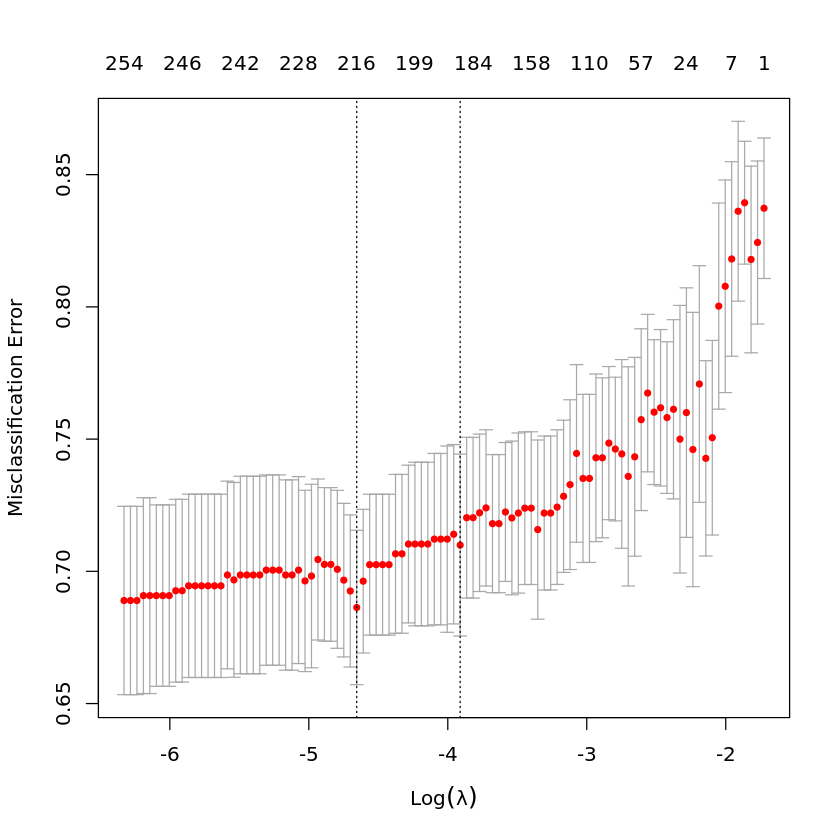

In [23]:
cv_mr_model
plot(cv_mr_model)

In [11]:
cv_min_idx <- cv_mr_model$index["min",]
# best cv performance
cv_best_cvm <- cv_mr_model$cvm[cv_min_idx]
# Std. error assoc. with best cv performance
cv_best_se <- cv_mr_model$cvsd[cv_min_idx]

mask_lambda <- cv_mr_model$lambda.min
# mask_lambda_genes <- as.matrix(coef(cv_mr_model, s = mask_lambda))[, 1] != 0
# subscript [-1, ...] is to skip the coefficient
# Since we're using "grouped", coefficients are same for each level of figo stage
mask_lambda_1 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_1)[-1, 1] != 0
# mask_lambda_2 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_2)[-1, 1] != 0
# mask_lambda_3 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_3)[-1, 1] != 0
# mask_lambda_4 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_4)[-1, 1] != 0

## Weighted baseline

In [12]:
maj_class <- which.max(ns)

In [13]:
weighted_baseline <- 1 - sum(figo_weights[y == paste0("figo_stage_", maj_class)]) / sum(figo_weights)

In [14]:
weighted_baseline

[1] 0.75

In [15]:
1 - cv_best_cvm / weighted_baseline

[1] 0.0849069

In [16]:
important_gene_df <- tibble(geneID = colnames(x)[mask_lambda_1])
# important_gene_df

In [17]:
if (save_res) {
    write_tsv(important_gene_df, paste0(dirs$analysis_dir, "/feature_selection/", unified_dsets[dset_idx], "_en_multinom_results.tsv"))
}